In [116]:
import re
import math
import warnings
import tqdm
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve
from matplotlib.pyplot import MultipleLocator
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
warnings.filterwarnings("ignore")

In [117]:
data1 = pd.read_excel('3a数据.xlsx').drop(['数据集划分'], axis=1)
data1.shape

(160, 106)

In [118]:
# 转换独热编码
xueya_list = []
for i in data1['血压']:
    y1 = i.split('/')[0]
    y2 = i.split('/')[1]
    if int(y1) > 139 or int(y1) < 90:
        status_i = 0
    elif int(y2) > 89 or int(y2) < 60:
        status_i = 0
    else:
        status_i = 1
    xueya_list.append(status_i)
data1['血压'] = np.array(xueya_list)
data1['性别_男'] = data1['性别'].apply(lambda x: 1 if x == '男' else 0)
data1['性别_女'] = data1['性别'].apply(lambda x: 1 if x == '女' else 0)
data1 = data1.drop(columns=['性别'])
x = data1['年龄'].values
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x.reshape(-1, 1))
binarizer = Binarizer(threshold=0.5)
x_binarized = binarizer.fit_transform(x_normalized)
data1['年龄'] = x_binarized
data1 = data1.drop(['流水号'], axis = 1)

In [119]:
# 归一化
# 比例变量变数值变量，归一化的是数值变量
# 假设data1是你的数据框
hm_columns = data1.filter(like='HM_').columns.tolist()
ed_columns = data1.filter(like='ED_').columns.tolist()
hm_columns.pop(0)
ed_columns.pop(0)
# 获取'HM_volume'和'ED_volume.0'列的值
hm_volume = data1['HM_volume']
ed_volume = data1['ED_volume.0']
# 将以'HM_'开头的列与'HM_volume'相乘
data1[hm_columns] = data1[hm_columns].mul(hm_volume, axis=0)
# 将以'ED_'开头的列与'ED_volume.0'相乘
data1[ed_columns] = data1[ed_columns].mul(ed_volume, axis=0)
# 创建 MinMaxScaler 对象
scaler = MinMaxScaler()
# 选择要归一化的列（除了 '年龄' 列之外的所有列）
columns_to_normalize = [col for col in data1.columns if col != '性别' and col != 'ID' and col != '90天mRS']
# 使用 MinMaxScaler 对所选列进行归一化
data1[columns_to_normalize] = scaler.fit_transform(data1[columns_to_normalize])

In [120]:
data2 = data1.drop(['HM_volume', 'ED_volume.0', 'ID'], axis = 1)
data2

,90天mRS,年龄,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,...,NCCT_original_firstorder_Median.Hemo,NCCT_original_firstorder_Minimum.Hemo,NCCT_original_firstorder_Range.Hemo,NCCT_original_firstorder_RobustMeanAbsoluteDeviation.Hemo,NCCT_original_firstorder_RootMeanSquared.Hemo,NCCT_original_firstorder_Skewness.Hemo,NCCT_original_firstorder_Uniformity.Hemo,NCCT_original_firstorder_Variance.Hemo,性别_男,性别_女
0,4.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794741,0.580976,0.461355,0.596541,0.747897,0.073091,0.233654,0.575522,0.0,1.0
1,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312688,0.302489,0.415018,0.784219,0.401521,0.432276,0.062318,0.678884,1.0,0.0
2,5.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.264387,0.173455,0.481753,0.421848,0.296407,0.379049,0.338820,0.323005,1.0,0.0
3,4.0,1.0,0.666667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.165330,0.145162,0.841963,0.543010,0.239052,0.550780,0.631206,0.475441,1.0,0.0
4,3.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.406462,0.494777,0.314800,0.505594,0.440597,0.383662,0.068760,0.401649,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,NaN,1.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.606803,0.322885,0.524279,0.619519,0.577253,0.164114,0.277650,0.558400,0.0,1.0
156,NaN,0.0,0.666667,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.235845,0.492805,0.332350,0.645449,0.373741,0.577202,0.118778,0.521251,1.0,0.0
157,NaN,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.343452,0.357229,0.372732,0.559288,0.408873,0.436945,0.129904,0.439126,1.0,0.0
158,NaN,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.196442,0.146322,0.385698,0.487636,0.229306,0.380374,0.221827,0.349817,1.0,0.0


In [121]:
data2_p1 = data2[:100]
data2_p2 = data2[100:]

In [122]:
data2_p1.head()

,90天mRS,年龄,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,...,NCCT_original_firstorder_Median.Hemo,NCCT_original_firstorder_Minimum.Hemo,NCCT_original_firstorder_Range.Hemo,NCCT_original_firstorder_RobustMeanAbsoluteDeviation.Hemo,NCCT_original_firstorder_RootMeanSquared.Hemo,NCCT_original_firstorder_Skewness.Hemo,NCCT_original_firstorder_Uniformity.Hemo,NCCT_original_firstorder_Variance.Hemo,性别_男,性别_女
0,4.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794741,0.580976,0.461355,0.596541,0.747897,0.073091,0.233654,0.575522,0.0,1.0
1,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312688,0.302489,0.415018,0.784219,0.401521,0.432276,0.062318,0.678884,1.0,0.0
2,5.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.264387,0.173455,0.481753,0.421848,0.296407,0.379049,0.338820,0.323005,1.0,0.0
3,4.0,1.0,0.666667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.165330,0.145162,0.841963,0.543010,0.239052,0.550780,0.631206,0.475441,1.0,0.0
4,3.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.406462,0.494777,0.314800,0.505594,0.440597,0.383662,0.068760,0.401649,1.0,0.0


In [123]:
data2_need_pca = data1.drop(['HM_volume', 'ED_volume.0', 'ID'], axis = 1)
data2_need_pca.head()

,90天mRS,年龄,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,...,NCCT_original_firstorder_Median.Hemo,NCCT_original_firstorder_Minimum.Hemo,NCCT_original_firstorder_Range.Hemo,NCCT_original_firstorder_RobustMeanAbsoluteDeviation.Hemo,NCCT_original_firstorder_RootMeanSquared.Hemo,NCCT_original_firstorder_Skewness.Hemo,NCCT_original_firstorder_Uniformity.Hemo,NCCT_original_firstorder_Variance.Hemo,性别_男,性别_女
0,4.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794741,0.580976,0.461355,0.596541,0.747897,0.073091,0.233654,0.575522,0.0,1.0
1,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312688,0.302489,0.415018,0.784219,0.401521,0.432276,0.062318,0.678884,1.0,0.0
2,5.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.264387,0.173455,0.481753,0.421848,0.296407,0.379049,0.338820,0.323005,1.0,0.0
3,4.0,1.0,0.666667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.165330,0.145162,0.841963,0.543010,0.239052,0.550780,0.631206,0.475441,1.0,0.0
4,3.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.406462,0.494777,0.314800,0.505594,0.440597,0.383662,0.068760,0.401649,1.0,0.0


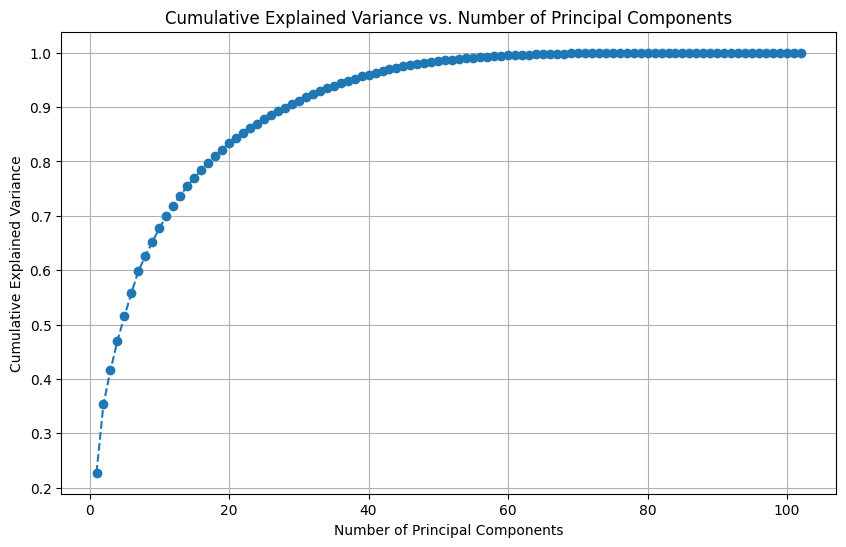

In [124]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 假设data1是你的DataFrame，其中第一列是y，其他列是x
y = data2_need_pca.iloc[:, 0]
X = data2_need_pca.iloc[:, 1:]

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 初始化PCA模型
pca = PCA()

# 拟合PCA模型
pca.fit(X_scaled)

# 累积解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# 绘制累积解释方差比例的图形
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()


In [125]:
# 寻找最接近0.9的累积解释方差的维度
target_variance = 0.9
optimal_dimension = next(i for i, var in enumerate(cumulative_explained_variance) if var >= target_variance) + 1  # 加1是因为索引从0开始

# 根据最优维度重新进行PCA
pca = PCA(n_components=optimal_dimension)
X_pca = pca.fit_transform(X_scaled)

# 创建一个新的DataFrame包含最优维度的主成分
column_names = [f"PC{i+1}" for i in range(optimal_dimension)]
df_pca = pd.DataFrame(data=X_pca, columns=column_names)

# 将y列添加回DataFrame
df_pca['y'] = y

# 打印最优维度
print(f"最优维度: {optimal_dimension}")

# 保存新的DataFrame到文件
df_pca.to_csv('pca_result.csv', index=False)  # 保存到csv文件中，你可以修改文件名和路径

# 打印新的DataFrame的前几行
df_pca.head()

最优维度: 29


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,y
0,4.418336,4.110910,-4.571476,1.160567,-0.583769,-1.251710,-1.498994,-0.144624,-1.081969,-0.212984,...,-0.843207,1.106732,0.778709,-0.600830,0.126878,-0.634860,-0.093491,-1.986938,1.714089,4.0
1,0.719469,-1.485016,-3.592325,-0.108989,-2.707113,0.437272,0.542298,-0.426788,0.689439,0.295181,...,-0.825235,-0.458695,-0.872547,0.031336,-0.058253,-0.328199,0.958966,-0.031043,-0.635396,0.0
2,5.648845,-3.339573,-1.912261,0.811085,-1.582474,-2.290038,0.647021,-0.626428,-0.439551,-0.924056,...,0.190045,-1.067195,-0.340648,-0.757071,0.930381,0.863314,-0.625970,0.183925,0.359224,5.0
3,3.365403,-4.066140,5.507794,-3.942182,0.025627,-0.881894,0.116458,2.341291,2.002114,3.626196,...,-1.325969,0.350234,-0.611359,0.092804,1.568779,-0.109939,0.111520,0.456633,0.904662,4.0
4,3.849019,0.501642,-2.421548,-2.223887,2.217132,0.618889,-2.923348,-3.836563,1.950592,-0.320196,...,-1.395366,2.037302,-0.220556,0.346945,0.477080,-0.553159,0.782542,-0.736013,0.945874,3.0


In [126]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,y
0,4.418336,4.110910,-4.571476,1.160567,-0.583769,-1.251710,-1.498994,-0.144624,-1.081969,-0.212984,...,-0.843207,1.106732,0.778709,-0.600830,0.126878,-0.634860,-0.093491,-1.986938,1.714089,4.0
1,0.719469,-1.485016,-3.592325,-0.108989,-2.707113,0.437272,0.542298,-0.426788,0.689439,0.295181,...,-0.825235,-0.458695,-0.872547,0.031336,-0.058253,-0.328199,0.958966,-0.031043,-0.635396,0.0
2,5.648845,-3.339573,-1.912261,0.811085,-1.582474,-2.290038,0.647021,-0.626428,-0.439551,-0.924056,...,0.190045,-1.067195,-0.340648,-0.757071,0.930381,0.863314,-0.625970,0.183925,0.359224,5.0
3,3.365403,-4.066140,5.507794,-3.942182,0.025627,-0.881894,0.116458,2.341291,2.002114,3.626196,...,-1.325969,0.350234,-0.611359,0.092804,1.568779,-0.109939,0.111520,0.456633,0.904662,4.0
4,3.849019,0.501642,-2.421548,-2.223887,2.217132,0.618889,-2.923348,-3.836563,1.950592,-0.320196,...,-1.395366,2.037302,-0.220556,0.346945,0.477080,-0.553159,0.782542,-0.736013,0.945874,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2.315389,-0.025073,3.093555,-4.012198,-0.389085,-2.192771,-1.183900,-0.346367,-4.804728,0.567160,...,0.022249,-0.195813,0.514463,-0.161307,-1.708029,-1.632749,-1.241372,-1.152283,1.373937,NaN
156,-6.513215,-1.856942,-0.738127,1.508818,-0.729298,2.138090,4.109756,2.269459,2.196031,0.933313,...,0.233045,1.105995,1.817151,0.820019,0.653872,-1.340408,-0.977055,1.337222,2.001667,NaN
157,-1.555348,0.567478,-1.672938,1.363858,-0.134262,0.077199,-1.747072,-1.517879,-0.035936,-1.200776,...,0.849717,-0.590303,-0.203979,0.105668,0.957650,-0.362678,0.427036,0.561364,0.500617,NaN
158,0.631320,-3.250165,0.424972,-1.774842,0.766077,0.757051,1.073398,-3.539850,0.106080,-2.057075,...,1.874335,-0.248677,-0.619869,-0.192821,-0.558432,0.389248,-0.832590,0.503370,0.717535,NaN
